# nodebook 09b: Optimizer tweaks

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from functools import partial

In [4]:
import torch.nn.functional as F

In [5]:
from lib.callbacks import *
from lib.model import *
from lib.data import *
from pathlib import Path

## MNIST

In [6]:
x_train,y_train,x_valid,y_valid = get_mnist_data(Path("/Users/kasparlund/.fastai/data/mnist.pkl.gz"))
x_train,x_valid   = normalize_to(x_train,x_valid)

x_train.mean(),x_train.std()

(tensor(0.0001), tensor(1.))

In [7]:
nh,bs, output_features = 50,512,y_train.max().item()+1
train_ds,valid_ds      = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl     = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                           DataLoader(valid_ds,  batch_size=bs*2) )
data                   = DataBunch( train_dl, valid_dl )

In [8]:

mnist_view = view_tfm(1,28,28)
n_filters_pr_layer = [8,16,32,32]
model     = get_cnn_model_ch1(n_filters_pr_layer, n_out_features=output_features)
init_cnn( model )
loss_func = F.cross_entropy
opt       = torch.optim.SGD(model.parameters(), lr=2.)
sched     = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs      = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback,
             partial(BatchTransformXCallback, tfm = mnist_view),
             LR_Finder
            ]
learn     = Learner( model, data, loss_func, opt=opt, cb_funcs=cbfs)

In [9]:
%time learn.fit(1)

epoch: 0
20 %
40 %
60 %
80 %
CPU times: user 26.6 s, sys: 166 ms, total: 26.7 s
Wall time: 3.95 s


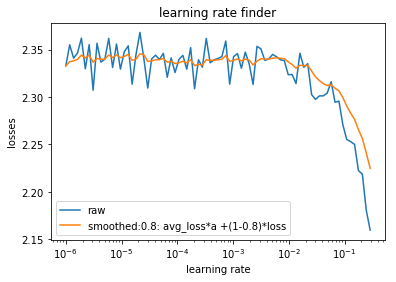

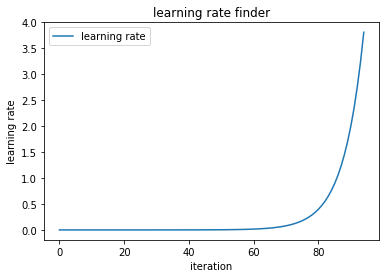

In [10]:
learn.find_subcription_by_cls(LR_Finder).plot_loss(0,16),plt.show()
learn.find_subcription_by_cls(LR_Finder).plot_lr()

In [11]:
#Training: create model again because current LRFInd does not restore settings in model and opt
mnist_view = view_tfm(1,28,28)
n_filters_pr_layer = [8,16,32,32]
model     = get_cnn_model_ch1(n_filters_pr_layer, n_out_features=output_features)
init_cnn( model )
loss_func = F.cross_entropy
opt       = torch.optim.SGD(model.parameters(), lr=.3)
sched     = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs      = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, partial(ParamScheduler, 'lr', sched),
             partial(BatchTransformXCallback, tfm = mnist_view),
             Recorder, partial(AvgStatsCallback,[accuracy])
             #SimpelCudaCallback
            ]

learn     = Learner( model, data, loss_func, opt=opt, cb_funcs=cbfs)

In [12]:
%time learn.fit(1)

epoch: 0
20 %
40 %
60 %
80 %
100 %
20 %
40 %
60 %
80 %
100 %
train: [1.187212578125, tensor(0.6106)]
valid: [0.2336703125, tensor(0.9315)]
CPU times: user 28.9 s, sys: 148 ms, total: 29.1 s
Wall time: 4.3 s


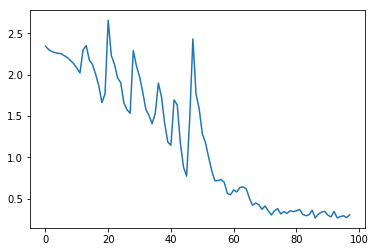

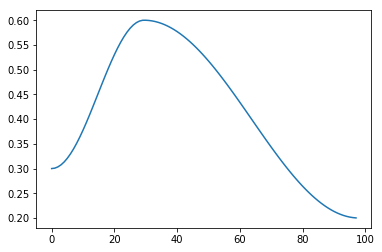

tensor(0.2188)

In [13]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.loss

## Imagenette data

## Export